In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load SB dataset

In [4]:
require 'paths'
require 'image'

relative = '/home/shrubb/Documents/BKP/Datasets/StanfordBkgd/'
labels = torch.load(relative .. 'labels_th.t7'):add(1):byte()
images = torch.FloatTensor(labels:size(1), 3, 240, 320)

collectgarbage()

filenames = {}
for file in paths.files(relative .. 'images_resized/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

for id, file in ipairs(filenames) do
    images[id]:copy(image.load(relative .. 'images_resized/' .. file))
end

labels:apply(function(x) return x == 0 and 2 or x end)

collectgarbage()

### Render labels for displaying

In [49]:
function renderLabels(labels, img)
    local LUT = {
        [0] = {0.0, 0.0, 0.0}, -- void
        [1] = {0.0, 1.0, 1.0}, -- sky
        [2] = {1.0, 1.0, 0.0}, -- tree
        [3] = {0.5, .25, 0.5}, -- road
        [4] = {0.0, 1.0, 0.0}, -- grass
        [5] = {0.0, 0.0, 1.0}, -- water
        [6] = {0.5, 0.0, 0.0}, -- building
        [7] = {1.0, 1.0, 1.0}, -- mountain
        [8] = {1.0, 0.0, 0.0}  -- foreground object
    }
    
    local retval = torch.FloatTensor(3, 240, 320)
    for i = 1,240 do
        for j = 1,320 do
            if not LUT[labels[i][j]] then
                print(labels[i][j], i, j)
            end
            for k, color in ipairs(LUT[labels[i][j]]) do
                retval[k][i][j] = color
            end
        end
    end
    
    if img then
        local labelsBlendCoeff = 0.82
        retval:mul(labelsBlendCoeff)
        retval:add(img * (1 - labelsBlendCoeff))
    end
    
    return retval
end

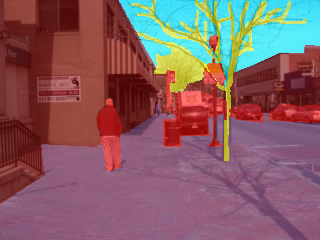

In [50]:
-- example blending
local k = 17
itorch.image(renderLabels(labels[k], images[k]))

In [5]:
require 'Integral-c-multi'

true	


In [8]:
mean = images:mean()
std = images:std()

images:add(-mean)
images:div(std)

In [76]:
net = nn.Sequential()
net:add(Integral(24, 240, 320)) -- 3*24
net:add(nn.SpatialConvolutionMM(3*24, 16, 1, 1, 1, 1)) 
net:add(nn.LeakyReLU(0.01))
net:add(Integral(12, 240, 320)) -- 12*16
net:add(nn.SpatialConvolutionMM(16*12, 8, 1, 1, 1, 1))
net:add(nn.Reshape(8, 240*320))
net:add(nn.Transpose({2, 1}))

params, gradParams = net:getParameters()

In [87]:
local function calcClassWeights(labels)
    local counts = {}
    labels:apply(function(x) counts[x] = (counts[x] or 0) + 1 end)
    counts[0] = nil

    local sum = 0
    for k, v in pairs(counts) do
        sum = sum + v
    end

    for k, v in pairs(counts) do
        counts[k] = sum / v -- inverse frequency
    end

    local classWeights = torch.Tensor(counts)
    classWeights:div(classWeights:mean())
    return classWeights
end

criterion = nn.CrossEntropyCriterion(calcClassWeights(labels))

In [160]:
require 'optim'

datasetIdx = 1

optimState = {
    learningRate = 8e-2,
    learningRateDecay = 0.9978
}

In [10]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()

In [161]:
losses = {}

In [252]:
avgLoss = 0

for iter = 1,715 do
--     windowDebugger_1:add(net:get(1))
--     windowDebugger_2:add(net:get(4))

    function feval(params)
        gradParams:zero()

        local input = image.rgb2yuv(images[datasetIdx])
        local target = labels[datasetIdx]:view(240*320)
        
        local outputs = net:forward(input)
        local loss = criterion:forward(outputs, target)

        local dLoss_dOutputs = criterion:backward(outputs, target)
        classifier:backward(net:get(4).output, dLoss_dOutputs)
        
        return loss, gradParams
    end

    local _, loss = optim.adam(feval, params, optimState)
    avgLoss = avgLoss + loss[1]
    
    collectgarbage()
    
    datasetIdx = datasetIdx % labels:size(1) + 1

    local outputFreq = 4
    if iter % outputFreq == 0 then
        losses[#losses+1] = avgLoss / outputFreq
        avgLoss = 0
    end
    
    local saveFreq = 50
    if iter % saveFreq == 0 then
        net:clearState()
        torch.save('SB segmentation/net.t7', net)
        torch.save('SB segmentation/loss-history.t7', losses)
--         windowDebugger_1:exportVideo('SB segmentation/int-layer-1.avi')
--         windowDebugger_2:exportVideo('SB segmentation/int-layer-2.avi')
    end
    
    if iter % labels:size(1) == 0 then
        print('Epoch ' .. (iter / labels:size(1)))
    end
    
    if iter % 20 == 0 then print('Iteration ' .. iter) end
end

20	


40	


60	


80	


100	


120	


140	


160	


180	


200	


220	


240	


260	


280	


300	


320	


340	


360	


380	


400	


420	


440	


460	


480	


500	


520	


540	


560	


580	


600	


620	


640	


660	


680	


700	


Epoch 1	


In [241]:
datasetIdx

1	


In [242]:
require 'gnuplot'
gnuplot.figure()
local lossesTensor = torch.Tensor(torch.load('SB segmentation/loss-history.t7')):clamp(-1, 4)
gnuplot.plot(lossesTensor, '-')
gnuplot.xlabel('Iteration')
gnuplot.ylabel('Loss')

In [209]:
function predict(net, example)
    local pred = net:forward(image.rgb2yuv(example))
    return select(2, nn.SoftMax():forward(pred):view(240, 320, 8):max(3)):squeeze()
end

In [243]:
print(classifier:get(1).weight:norm(1))
print(classifier:get(3).weight:norm(1))
print(classifier:get(1).weight:min(), classifier:get(1).weight:max())
print(classifier:get(3).weight:min(), classifier:get(3).weight:max())

58928.40658919	
1364.1771736997	
-14.392915725708	14.374321937561	
-6.66028881073	8.2288427352905	


In [164]:
print(classifier:get(1).weight:norm(1))
print(classifier:get(3).weight:norm(1))

776.51373275234	
42.267112597772	


In [163]:
net = torch.load('SB segmentation/Saved v1 (0 hidden layers)/net.t7')

net:remove()
net:remove()
net:remove()

classifier = nn.Sequential()

classifier:add(nn.SpatialConvolutionMM(192, 112, 1, 1, 1, 1))
classifier:add(nn.LeakyReLU(0.01))
classifier:add(nn.SpatialConvolutionMM(112,   8, 1, 1, 1, 1))
classifier:add(nn.Reshape(8, 240*320))
classifier:add(nn.Transpose({2, 1}))

net:add(classifier)

params, gradParams = classifier:getParameters()

In [188]:
net_single = torch.load('SB segmentation/Saved v1 (0 hidden layers)/net.t7')

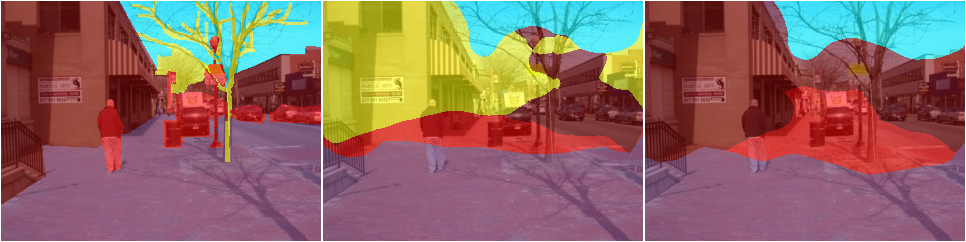

In [256]:
local k =17 
itorch.image{
    renderLabels(labels[k], images[k]),
    renderLabels(predict(net_single, images[k]), images[k]),
    renderLabels(predict(net, images[k]), images[k])
}